# Análise NLP de Chat em Português (pt-BR)

Este notebook analisa conversas de chat para identificar padrões linguísticos, especialmente **sentenças que usam as palavras menos frequentes**.

In [1]:
import re
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# NLTK imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Carregamento e Parsing dos Dados

In [2]:
# Load chat data
chat_file = Path('../../data/raw/___chat.txt')

with open(chat_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()

print(f"Total de linhas no arquivo: {len(lines)}")
print(f"\nPrimeiras linhas:")
for line in lines[:5]:
    print(line.strip())

Total de linhas no arquivo: 4137

Primeiras linhas:
28/12/2024 23:54 - As mensagens e ligações são protegidas com a criptografia de ponta a ponta. Somente as pessoas que fazem parte da conversa podem ler, ouvir e compartilhar esse conteúdo. Saiba mais
28/12/2024 18:25 - ‎Luca Ribeiro criou o grupo "inimigo oculto"
28/12/2024 23:54 - Você entrou usando o link de convite do grupo
29/12/2024 07:26 - Luca Ribeiro: Mandei o link pro thiago
29/12/2024 07:27 - Luca Ribeiro: Faz sentido


In [3]:
# Parse WhatsApp chat format
# Pattern: DD/MM/YYYY HH:MM - Username: Message
pattern = r'^(\d{2}/\d{2}/\d{4} \d{2}:\d{2}) - ([^:]+): (.+)$'

messages = []

for line in lines:
    line = line.strip()
    match = re.match(pattern, line)
    
    if match:
        timestamp, user, message = match.groups()
        # Skip system messages and media
        if not message.startswith('<Mídia oculta>') and not message.startswith('‎'):
            messages.append({
                'timestamp': timestamp,
                'user': user.strip(),
                'message': message.strip()
            })

df = pd.DataFrame(messages)
print(f"\nTotal de mensagens válidas: {len(df)}")
df.head(10)


Total de mensagens válidas: 3428


,timestamp,user,message
0,29/12/2024 07:26,Luca Ribeiro,Mandei o link pro thiago
1,29/12/2024 07:27,Luca Ribeiro,Faz sentido
2,29/12/2024 11:02,Rafael 🐐,Namoradas?
3,29/12/2024 11:34,Eric 🦁,"pode ser, mas fica mais difícil comprar presen..."
4,29/12/2024 11:34,Eric 🦁,mas por mim no prob
5,29/12/2024 16:26,Rafael 🐐,Eai?
6,29/12/2024 16:26,Luna,Por mim pode ser
7,29/12/2024 16:26,Rafael 🐐,Acho melhor convidar logo todo mundo pra dar t...
8,29/12/2024 16:26,Luna,Ss
9,29/12/2024 16:28,Rafael 🐐,Estamos querendo organizar um amigo oculto pro...


## 2. Pré-processamento e Tokenização

In [4]:
# Load Portuguese stopwords
stop_words = set(stopwords.words('portuguese'))

# Add custom stopwords common in chat
custom_stopwords = {'kk', 'kkk', 'kkkk', 'kkkkk', 'kkkkkk', 'kkkkkkk', 'kkkkkkkk',
                     'rs', 'rsrs', 'haha', 'kaka', 'kakaka', 'kakakaka',
                     'tb', 'tbm', 'vc', 'vcs', 'msm', 'mt', 'q', 'n', 'aí', 'ai',
                     'pra', 'pro', 'né', 'ne', 'tá', 'ta', 'ok', 'blz'}
stop_words.update(custom_stopwords)

print(f"Total de stopwords: {len(stop_words)}")
print(f"\nExemplos de stopwords: {list(stop_words)[:20]}")

Total de stopwords: 238

Exemplos de stopwords: ['tua', 'essa', 'nós', 'essas', 'temos', 'no', 'entre', 'hei', 'já', 'se', 'os', 'houverão', 'tinha', 'kkk', 'nos', 'fora', 'houveriam', 'estejam', 'vocês', 'kkkkkkk']


In [5]:
def clean_text(text):
    """Clean and normalize text"""
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions and special chars
    text = re.sub(r'@\S+', '', text)
    # Remove emojis and special unicode (keep Portuguese chars)
    text = re.sub(r'[^\w\s\-áàâãéêíóôõúüçÁÀÂÃÉÊÍÓÔÕÚÜÇ]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def tokenize_and_filter(text):
    """Tokenize and remove stopwords"""
    tokens = word_tokenize(text, language='portuguese')
    # Filter out stopwords, short tokens, and numeric words
    filtered = [token for token in tokens
                if token not in stop_words
                and len(token) > 2
                and not token.isdigit()  # Remove pure numbers
                and not re.match(r'^[\d\-]+$', token)]  # Remove number-like patterns (e.g., "60-100", "99963-2515")
    return filtered

# Apply preprocessing
df['cleaned'] = df['message'].apply(clean_text)
df['tokens'] = df['cleaned'].apply(tokenize_and_filter)
df['num_tokens'] = df['tokens'].apply(len)

print(f"\nExemplos de processamento:")
for idx in range(min(5, len(df))):
    print(f"\nOriginal: {df.iloc[idx]['message']}")
    print(f"Tokens: {df.iloc[idx]['tokens']}")


Exemplos de processamento:

Original: Mandei o link pro thiago
Tokens: ['mandei', 'link', 'thiago']

Original: Faz sentido
Tokens: ['faz', 'sentido']

Original: Namoradas?
Tokens: ['namoradas']

Original: pode ser, mas fica mais difícil comprar presente pra média kkkkkk
Tokens: ['pode', 'fica', 'difícil', 'comprar', 'presente', 'média']

Original: mas por mim no prob
Tokens: ['mim', 'prob']


## 3. Análise de Frequência de Palavras

In [6]:
# Get all tokens from all messages
all_tokens = [token for tokens in df['tokens'] for token in tokens]

print(f"Total de tokens (após limpeza): {len(all_tokens)}")
print(f"Vocabulário único: {len(set(all_tokens))}")

# Calculate word frequency
word_freq = Counter(all_tokens)
freq_dist = FreqDist(all_tokens)

print(f"\n=== 20 PALAVRAS MAIS FREQUENTES ===")
for word, count in word_freq.most_common(20):
    print(f"{word:20s}: {count:3d} vezes")

Total de tokens (após limpeza): 9366
Vocabulário único: 3167

=== 20 PALAVRAS MAIS FREQUENTES ===
acho                : 116 vezes
vai                 : 104 vezes
dia                 : 101 vezes
gnt                 :  81 vezes
vou                 :  76 vezes
ent                 :  69 vezes
sim                 :  66 vezes
boa                 :  59 vezes
pode                :  58 vezes
mim                 :  57 vezes
bom                 :  50 vezes
melhor              :  47 vezes
aqui                :  47 vezes
casa                :  46 vezes
mensagem            :  45 vezes
ter                 :  42 vezes
fazer               :  39 vezes
posso               :  38 vezes
bem                 :  37 vezes
dps                 :  35 vezes


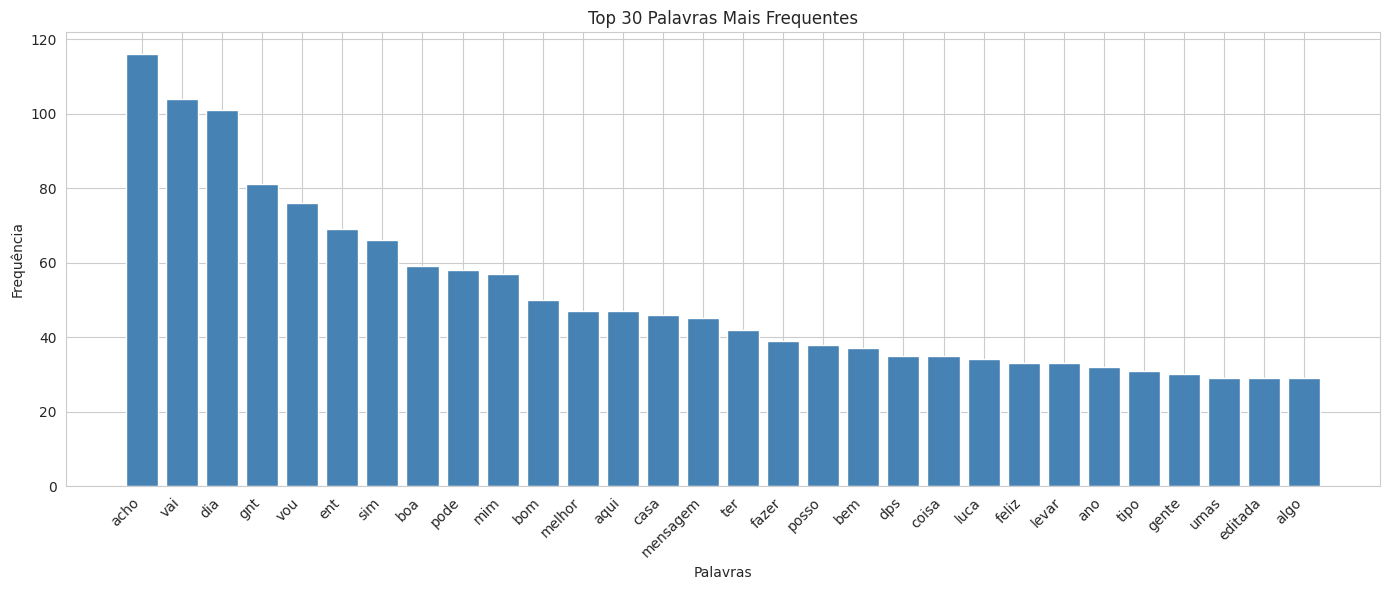

In [7]:
# Plot most common words
top_n = 30
top_words = word_freq.most_common(top_n)
words, counts = zip(*top_words)

plt.figure(figsize=(14, 6))
plt.bar(range(len(words)), counts, color='steelblue')
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title(f'Top {top_n} Palavras Mais Frequentes')
plt.tight_layout()
plt.show()

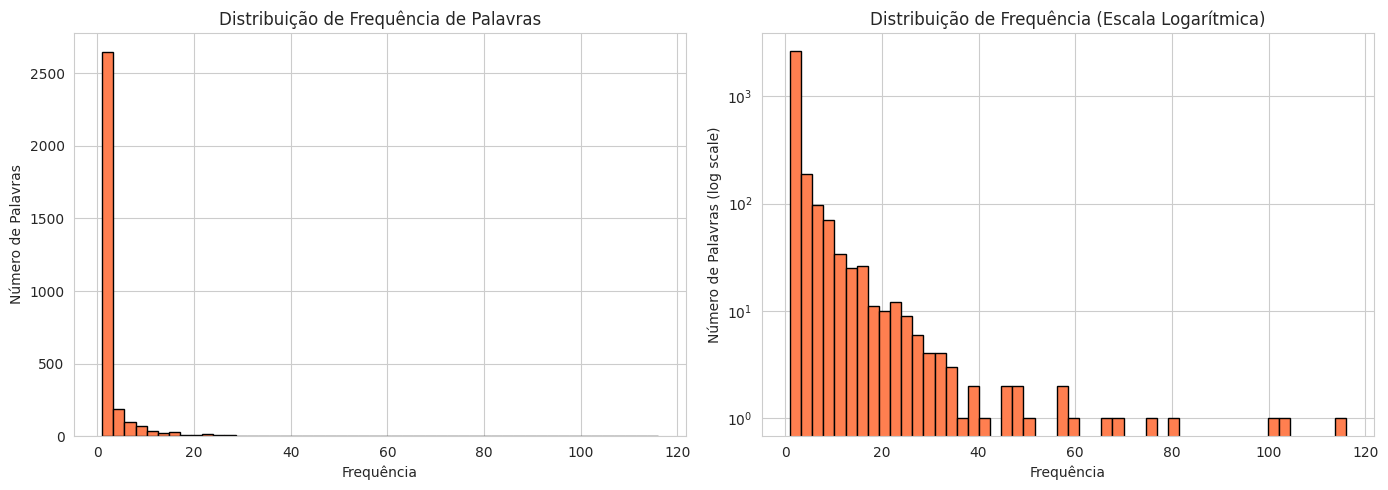


Estatísticas da frequência:
Média: 2.96
Mediana: 1.00
Desvio padrão: 6.29


In [8]:
# Plot word frequency distribution
frequency_values = list(word_freq.values())

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(frequency_values, bins=50, color='coral', edgecolor='black')
plt.xlabel('Frequência')
plt.ylabel('Número de Palavras')
plt.title('Distribuição de Frequência de Palavras')

plt.subplot(1, 2, 2)
plt.hist(frequency_values, bins=50, color='coral', edgecolor='black', log=True)
plt.xlabel('Frequência')
plt.ylabel('Número de Palavras (log scale)')
plt.title('Distribuição de Frequência (Escala Logarítmica)')

plt.tight_layout()
plt.show()

print(f"\nEstatísticas da frequência:")
print(f"Média: {np.mean(frequency_values):.2f}")
print(f"Mediana: {np.median(frequency_values):.2f}")
print(f"Desvio padrão: {np.std(frequency_values):.2f}")

## 4. Palavras Menos Frequentes (Palavras Raras)

In [9]:
# Get least common words (hapax legomena - words that appear only once)
hapax_legomena = [word for word, count in word_freq.items() if count == 1]
rare_words = [word for word, count in word_freq.items() if count <= 3]

print(f"\n=== ESTATÍSTICAS DE PALAVRAS RARAS ===")
print(f"Hapax legomena (aparecem apenas 1 vez): {len(hapax_legomena)}")
print(f"Palavras raras (≤ 3 ocorrências): {len(rare_words)}")
print(f"\nExemplos de hapax legomena:")
print(hapax_legomena[:30])


=== ESTATÍSTICAS DE PALAVRAS RARAS ===
Hapax legomena (aparecem apenas 1 vez): 1953
Palavras raras (≤ 3 ocorrências): 2646

Exemplos de hapax legomena:
['link', 'média', 'participe', 'morde', 'kakakakakakak', 'btw', 'inclui', 'bento', 'algoritimo', 'somente', 'relacionadas', 'tiradas', 'nop', 'baixei', 'pares', 'voltamos', 'vms', 'aquii', 'showw', 'links', 'olá', 'creio', 'minimo', 'máximo', 'suponho', 'reserva', 'usei', 'contava', 'namorado', 'sorteando']


In [10]:
# Show words by frequency tiers
print("\n=== PALAVRAS POR NÍVEL DE RARIDADE ===")

for max_freq in [1, 2, 3, 4, 5]:
    words_at_freq = [word for word, count in word_freq.items() if count == max_freq]
    print(f"\nPalavras com exatamente {max_freq} ocorrência(s): {len(words_at_freq)}")
    print(f"Exemplos: {words_at_freq[:15]}")


=== PALAVRAS POR NÍVEL DE RARIDADE ===

Palavras com exatamente 1 ocorrência(s): 1953
Exemplos: ['link', 'média', 'participe', 'morde', 'kakakakakakak', 'btw', 'inclui', 'bento', 'algoritimo', 'somente', 'relacionadas', 'tiradas', 'nop', 'baixei', 'pares']

Palavras com exatamente 2 ocorrência(s): 483
Exemplos: ['mandei', 'namoradas', 'prob', 'eai', 'organizar', 'esquecemos', 'numero', 'coloco', 'coloca', 'evento', 'restrições', 'põe', 'envia', 'whatsapp', 'pfto']

Palavras com exatamente 3 ocorrência(s): 210
Exemplos: ['difícil', 'convidar', 'super', 'ciclo', 'usar', 'principio', 'valor', 'aguardando', 'tirando', 'ninguém', 'comprado', 'lol', 'nomes', 'família', 'ajudar']

Palavras com exatamente 4 ocorrência(s): 113
Exemplos: ['sentido', 'faixa', 'sorteio', 'sao', 'okayy', 'vice', 'kkkkkkkkkkkkkkkkkk', 'caras', 'tênis', 'conhece', 'povo', 'amor', 'búzios', 'viu', 'esperando']

Palavras com exatamente 5 ocorrência(s): 76
Exemplos: ['fim', 'participar', 'acham', 'namorada', 'poder', '

In [11]:
# Create a Python dictionary with rare words (only 1 occurrence) and their sentences + users
# Key: rare word (frequency = 1, hapax legomena)
# Value: tuple (user, sentence, timestamp)

rare_words_dict = {}

# Get set of words that appear exactly once
hapax_words_set = set([word for word, count in word_freq.items() if count == 1])

# Filter messages with tokens (same logic as will be used in Cell 17)
df_with_tokens = df[df['num_tokens'] > 0].copy()

# Iterate through all valid messages
for idx, row in df_with_tokens.iterrows():
    message = row['message']
    user = row['user']
    timestamp = row['timestamp']
    tokens = row['tokens']
    
    # Check each token in the message
    for token in tokens:
        if token in hapax_words_set:
            # Since it only appears once, just store it directly (not in a list)
            rare_words_dict[token] = (user, message, timestamp)

print(f"\n📚 Dicionário de palavras únicas criado: {len(rare_words_dict)} palavras")
print(f"   (Palavras que aparecem apenas 1 vez - Hapax Legomena)")
print("="*80)
print("\nExemplos do dicionário:")
print("="*80)

# Show some examples
count = 0
for word in sorted(rare_words_dict.keys())[:15]:
    user, sent, timestamp = rare_words_dict[word]
    print(f"\n'{word}':")
    print(f"  [{user}] em {timestamp}")
    print(f"  → {sent}")
    count += 1

# Store in variable
RARE_WORDS_DICT = rare_words_dict

print(f"\n✅ Variável 'RARE_WORDS_DICT' criada com {len(RARE_WORDS_DICT)} palavras únicas")
print(f"\nEstrutura: {{'palavra_única': ('usuário', 'sentença', 'timestamp')}}")

# Example of how to access the data
print(f"\n💡 Exemplo de acesso:")
print(f"   user, sentence, timestamp = RARE_WORDS_DICT['palavra']")
if len(rare_words_dict) > 0:
    example_word = sorted(rare_words_dict.keys())[0]
    example_user, example_sentence, example_timestamp = rare_words_dict[example_word]
    print(f"\n   user, sentence, timestamp = RARE_WORDS_DICT['{example_word}']")
    print(f"   → user = '{example_user}'")
    sentence_preview = example_sentence if len(example_sentence) <= 50 else example_sentence[:50] + '...'
    print(f"   → sentence = '{sentence_preview}'")
    print(f"   → timestamp = '{example_timestamp}'")


📚 Dicionário de palavras únicas criado: 1953 palavras
   (Palavras que aparecem apenas 1 vez - Hapax Legomena)

Exemplos do dicionário:

'10l':
  [Beatriz Figueiredo] em 10/03/2025 13:41
  → De levar algo até 10L

'10min':
  [Carol 🧠] em 24/08/2025 20:02
  → Concidentemente fica ha 10min da minha casa d campo onde podemos até fcr d graça

'13h':
  [Thiago B] em 02/05/2025 16:55
  → Opaaa, só p confirmar que vai ser amanhã 13h msm!

'15h':
  [Rafael 🐐] em 13/01/2026 10:58
  → Pessoal, vcs podem fazer um pouco mais cedo, tipo 15h? Só pra acabar mais cedo, pq 21 é dia útil e acho que seria bom voltar mais cedo

'16h':
  [Luna] em 30/08/2025 14:59
  → Koe, eu conseguido pedir pra algum dos jovens guerreiros chegar as 16h so pra pegar a quadra

'17h30':
  [Luca Ribeiro] em 21/03/2025 06:33
  → Umas 17h30/18, por aí tlvz

'18h40':
  [Luca 🗓🎲] em 30/10/2025 17:37
  → Eu terminando umas 18h ja ralo direto, umas 18h40 no max ja devo conseguir chegar

'200reais':
  [Ricardo 🏹] em 08/10/2025 17:

## 5. ⭐ SENTENÇAS COM PALAVRAS MENOS FREQUENTES ⭐

Esta é a análise principal: encontrar sentenças que usam as palavras mais raras.

In [12]:
def calculate_sentence_rarity_score(tokens, word_freq):
    """
    Calculate rarity score for a sentence.
    Lower score = more rare words used.
    Using harmonic mean to heavily penalize common words.
    """
    if not tokens:
        return None
    
    frequencies = [word_freq.get(token, 0) for token in tokens]
    
    # Filter out zero frequencies
    frequencies = [f for f in frequencies if f > 0]
    
    if not frequencies:
        return None
    
    # Harmonic mean (gives more weight to rare words)
    harmonic_mean = len(frequencies) / sum(1/f for f in frequencies)
    
    return harmonic_mean

def calculate_min_word_frequency(tokens, word_freq):
    """
    Return the minimum frequency of any word in the sentence.
    """
    if not tokens:
        return None
    frequencies = [word_freq.get(token, 0) for token in tokens if word_freq.get(token, 0) > 0]
    return min(frequencies) if frequencies else None

# Calculate scores for all messages
df['rarity_score'] = df['tokens'].apply(lambda x: calculate_sentence_rarity_score(x, word_freq))
df['min_word_freq'] = df['tokens'].apply(lambda x: calculate_min_word_frequency(x, word_freq))

# Filter out messages with no valid tokens
df_valid = df[df['num_tokens'] > 0].copy()

# Filter out messages with None rarity scores (no valid tokens found in word_freq)
df_valid = df_valid[df_valid['rarity_score'].notna()].copy()

print(f"\nMensagens válidas para análise: {len(df_valid)}")


Mensagens válidas para análise: 3158


In [13]:
# Top sentences with rarest words (lowest rarity score)
top_rare_sentences = df_valid.nsmallest(30, 'rarity_score')

print("\n" + "="*80)
print("🔍 TOP 30 SENTENÇAS QUE USAM AS PALAVRAS MENOS FREQUENTES")
print("="*80)

for idx, row in top_rare_sentences.iterrows():
    print(f"\n[{row['user']}] em {row['timestamp']}")
    print(f"Mensagem: {row['message']}")
    print(f"Tokens: {row['tokens']}")
    print(f"Score de raridade: {row['rarity_score']:.3f}")
    min_freq = row['min_word_freq']
    print(f"Menor frequência: {min_freq if min_freq is not None else 'N/A'}")
    
    # Show frequency of each word
    word_freqs = [(token, word_freq.get(token, 0)) for token in row['tokens']]
    print(f"Frequências: {word_freqs}")
    print("-" * 80)


🔍 TOP 30 SENTENÇAS QUE USAM AS PALAVRAS MENOS FREQUENTES

[Rafael 🐐] em 29/12/2024 16:43
Mensagem: KAKAKAKAKAKAK
Tokens: ['kakakakakakak']
Score de raridade: 1.000
Menor frequência: 1.0
Frequências: [('kakakakakakak', 1)]
--------------------------------------------------------------------------------

[Eric 🦁] em 29/12/2024 16:49
Mensagem: nop
Tokens: ['nop']
Score de raridade: 1.000
Menor frequência: 1.0
Frequências: [('nop', 1)]
--------------------------------------------------------------------------------

[Rafael 🐐] em 29/12/2024 22:43
Mensagem: Showw
Tokens: ['showw']
Score de raridade: 1.000
Menor frequência: 1.0
Frequências: [('showw', 1)]
--------------------------------------------------------------------------------

[Beatriz Figueiredo] em 30/12/2024 12:15
Mensagem: Please
Tokens: ['please']
Score de raridade: 1.000
Menor frequência: 1.0
Frequências: [('please', 1)]
--------------------------------------------------------------------------------

[Rafael 🐐] em 30/12/2024

## 5.1. ⭐ DataFrame Completo com Sentenças Raras ⭐

Aqui criamos um DataFrame com **TODAS** as sentenças que contêm palavras que apareceram **menos de 3 vezes** (frequência ≤ 2), ordenadas pela quantidade de palavras raras em cada sentença.

In [14]:
# Create DataFrame with ALL sentences containing rare words (frequency <= 2)
# Words that appeared less than 3 times (i.e., 1 or 2 times)
very_rare_words = set([word for word, count in word_freq.items() if count <= 2])

def count_rare_words_in_sentence(tokens):
    """Count how many rare words (<=2 occurrences) are in the sentence"""
    return sum(1 for token in tokens if token in very_rare_words)

def get_rare_words_from_sentence(tokens):
    """Get list of rare words in the sentence"""
    return [token for token in tokens if token in very_rare_words]

# Add rare word count to dataframe
df_valid['num_rare_words'] = df_valid['tokens'].apply(count_rare_words_in_sentence)
df_valid['rare_words_list'] = df_valid['tokens'].apply(get_rare_words_from_sentence)

# Filter to only sentences with at least one rare word
df_with_rare = df_valid[df_valid['num_rare_words'] > 0].copy()

# Sort by number of rare words (descending)
df_with_rare_sorted = df_with_rare.sort_values('num_rare_words', ascending=False)

print("\n" + "="*80)
print(f"📋 TODAS AS SENTENÇAS COM PALAVRAS RARAS (frequência ≤ 2)")
print("="*80)
print(f"\nTotal de sentenças: {len(df_with_rare_sorted)}")
print(f"Total de palavras raras (≤2 ocorrências): {len(very_rare_words)}")
print("\nOrdenadas por quantidade de palavras raras por sentença:")
print("="*80)

# Display the dataframe
display_df = df_with_rare_sorted[['timestamp', 'user', 'message', 'num_rare_words', 'rare_words_list']].copy()
display_df.columns = ['Data/Hora', 'Usuário', 'Mensagem', 'Qtd Palavras Raras', 'Palavras Raras']

print(f"\n{display_df.head(50).to_string()}")

print("\n" + "="*80)
print(f"💾 DataFrame completo disponível em: df_with_rare_sorted")
print("="*80)


📋 TODAS AS SENTENÇAS COM PALAVRAS RARAS (frequência ≤ 2)

Total de sentenças: 1789
Total de palavras raras (≤2 ocorrências): 2436

Ordenadas por quantidade de palavras raras por sentença:

             Data/Hora              Usuário                                                                                                                                                                                                                                                                                                                                                                                                            Mensagem  Qtd Palavras Raras                                                                                                                             Palavras Raras
1607  24/08/2025 20:02              Carol 🧠                                                                                                 Po conheço um pertinho da capital do balonismo, onde tem o maio

In [15]:
# Export the DataFrame with rare words
output_dir = Path('../../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / 'sentences_with_rare_words_detailed.csv'

# Prepare export dataframe
export_df = df_with_rare_sorted[['timestamp', 'user', 'message', 'tokens', 
                                   'num_rare_words', 'rare_words_list', 
                                   'rarity_score', 'min_word_freq']].copy()

# Convert lists to strings for CSV
export_df['tokens'] = export_df['tokens'].apply(lambda x: ', '.join(x))
export_df['rare_words_list'] = export_df['rare_words_list'].apply(lambda x: ', '.join(x))

export_df.to_csv(output_file, index=False)

print(f"\n✅ DataFrame exportado para: {output_file}")
print(f"   Total de linhas: {len(export_df)}")

# Show some statistics about rare words per sentence
print("\n📊 Distribuição de palavras raras por sentença:")
print(df_with_rare_sorted['num_rare_words'].value_counts().sort_index(ascending=False).head(10))


✅ DataFrame exportado para: ../../data/processed/sentences_with_rare_words_detailed.csv
   Total de linhas: 1789

📊 Distribuição de palavras raras por sentença:
num_rare_words
14      2
10      1
9       1
8       3
7       7
6      12
5      23
4      58
3     134
2     430
Name: count, dtype: int64


In [16]:
# Alternative: sentences containing hapax legomena
df_valid['has_hapax'] = df_valid['tokens'].apply(lambda tokens: any(token in hapax_legomena for token in tokens))
df_with_hapax = df_valid[df_valid['has_hapax']].copy()

print("\n" + "="*80)
print(f"📝 SENTENÇAS CONTENDO HAPAX LEGOMENA (palavras únicas): {len(df_with_hapax)}")
print("="*80)

for idx, row in df_with_hapax.head(20).iterrows():
    hapax_in_sentence = [token for token in row['tokens'] if token in hapax_legomena]
    
    print(f"\n[{row['user']}] em {row['timestamp']}")
    print(f"Mensagem: {row['message']}")
    print(f"Palavras únicas encontradas: {hapax_in_sentence}")
    print("-" * 80)


📝 SENTENÇAS CONTENDO HAPAX LEGOMENA (palavras únicas): 1338

[Luca Ribeiro] em 29/12/2024 07:26
Mensagem: Mandei o link pro thiago
Palavras únicas encontradas: ['link']
--------------------------------------------------------------------------------

[Eric 🦁] em 29/12/2024 11:34
Mensagem: pode ser, mas fica mais difícil comprar presente pra média kkkkkk
Palavras únicas encontradas: ['média']
--------------------------------------------------------------------------------

[Beatriz Figueiredo] em 29/12/2024 16:42
Mensagem: Msm que n participe, coloca ela, eric
Palavras únicas encontradas: ['participe']
--------------------------------------------------------------------------------

[Carol 🧠] em 29/12/2024 16:43
Mensagem: A gnt n morde eric
Palavras únicas encontradas: ['morde']
--------------------------------------------------------------------------------

[Rafael 🐐] em 29/12/2024 16:43
Mensagem: KAKAKAKAKAKAK
Palavras únicas encontradas: ['kakakakakakak']
--------------------------

In [17]:
df_with_hapax

,timestamp,user,message,cleaned,tokens,num_tokens,rarity_score,min_word_freq,num_rare_words,rare_words_list,has_hapax
0,29/12/2024 07:26,Luca Ribeiro,Mandei o link pro thiago,mandei o link pro thiago,"[mandei, link, thiago]",3,1.914894,1.0,2,"[mandei, link]",True
3,29/12/2024 11:34,Eric 🦁,"pode ser, mas fica mais difícil comprar presen...",pode ser mas fica mais difícil comprar present...,"[pode, fica, difícil, comprar, presente, média]",6,4.028177,1.0,1,[média],True
17,29/12/2024 16:42,Beatriz Figueiredo,"Msm que n participe, coloca ela, eric",msm que n participe coloca ela eric,"[participe, coloca, eric]",3,1.914894,1.0,2,"[participe, coloca]",True
20,29/12/2024 16:43,Carol 🧠,A gnt n morde eric,a gnt n morde eric,"[gnt, morde, eric]",3,2.780320,1.0,1,[morde],True
21,29/12/2024 16:43,Rafael 🐐,KAKAKAKAKAKAK,kakakakakakak,[kakakakakakak],1,1.000000,1.0,1,[kakakakakakak],True
...,...,...,...,...,...,...,...,...,...,...,...
3420,18/01/2026 21:56,Luca 🗓🎲,@⁨~Carol Germano⁩ me acompanhe nisso pf,germano me acompanhe nisso pf,"[germano, acompanhe, nisso]",3,2.413793,1.0,1,[acompanhe],True
3421,18/01/2026 22:10,Beatriz Figueiredo,Putss,putss,[putss],1,1.000000,1.0,1,[putss],True
3422,18/01/2026 22:13,Luca 🗓🎲,"N é um problema, item essencial no meu lar",n é um problema item essencial no meu lar,"[problema, item, essencial, lar]",4,1.285714,1.0,3,"[item, essencial, lar]",True
3424,18/01/2026 22:14,Ricardo 🏹,Já vi que é bom levar meu kit de bartender kkk...,já vi que é bom levar meu kit de bartender kkk...,"[bom, levar, kit, bartender]",4,2.580141,1.0,2,"[kit, bartender]",True


## 6. Análise por Usuário


=== ESTATÍSTICAS POR USUÁRIO ===
                     num_messages  total_tokens  avg_rarity_score
user                                                             
Luca Ribeiro                  444          1320          7.374605
Beatriz Figueiredo            413          1001         10.767167
Luca 🗓🎲                       343          1119          7.099612
Ursinha Polar 🐻‍❄️🤍           339           954          9.851585
Rafael 🐐                      326          1024          9.352452
Eric 🦁                        310           807         10.845479
+55 21 98955-3372             270           622          6.008710
Luna                          246           952          9.853042
Carol 🧠                       225           750          6.088466
Thiago B                      115           336          9.747244
Ricardo 🏹                      99           423          9.417837
Thiago 🇨🇳                      28            58          6.017340


/tmp/ipykernel_189345/1678517336.py:33: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_189345/1678517336.py:33: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_189345/1678517336.py:33: UserWarning: Glyph 128059 (\N{BEAR FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_189345/1678517336.py:33: UserWarning: Glyph 129293 (\N{WHITE HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_189345/1678517336.py:33: UserWarning: Glyph 128016 (\N{GOAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_189345/1678517336.py:33: UserWarning: Glyph 129409 (\N{LION FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_189345/1678517336.py:33: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_189345/1678517336.py:33:

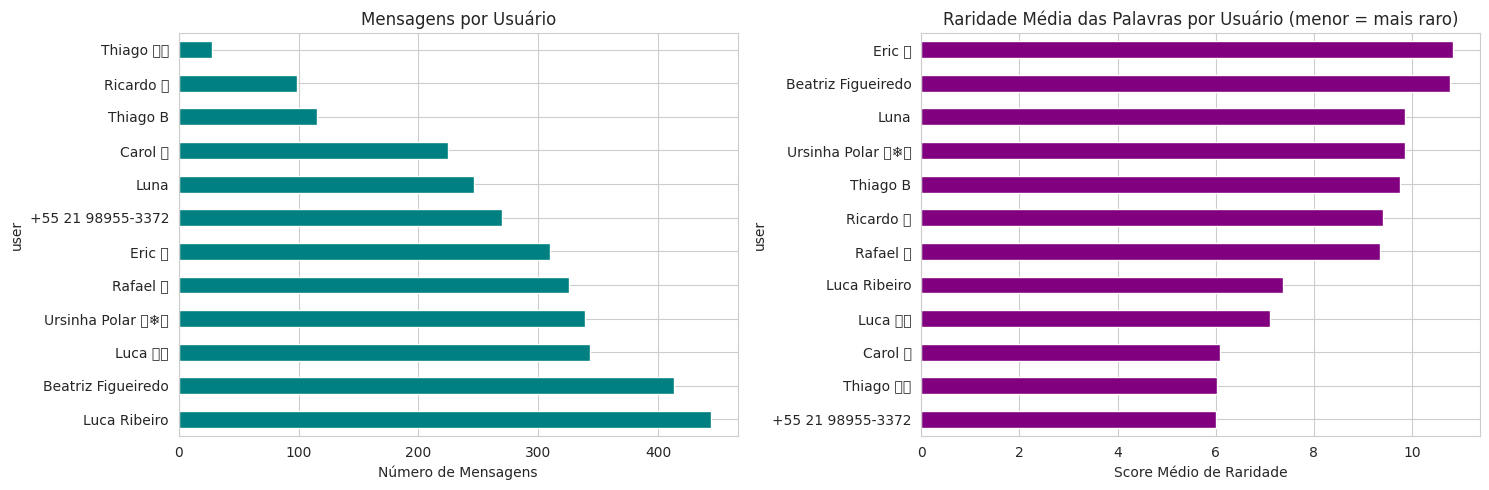

In [18]:
# User statistics - use df_valid which has valid rarity scores
user_stats = df_valid.groupby('user').agg({
    'message': 'count',
    'num_tokens': 'sum',
    'rarity_score': 'mean'
}).rename(columns={
    'message': 'num_messages',
    'num_tokens': 'total_tokens',
    'rarity_score': 'avg_rarity_score'
}).sort_values('num_messages', ascending=False)

print("\n=== ESTATÍSTICAS POR USUÁRIO ===")
print(user_stats)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Messages per user
user_stats['num_messages'].plot(kind='barh', ax=axes[0], color='teal')
axes[0].set_xlabel('Número de Mensagens')
axes[0].set_title('Mensagens por Usuário')

# Average rarity score per user (only for users with valid scores)
user_stats_valid = user_stats[user_stats['avg_rarity_score'].notna()]
if len(user_stats_valid) > 0:
    user_stats_valid['avg_rarity_score'].sort_values().plot(kind='barh', ax=axes[1], color='purple')
    axes[1].set_xlabel('Score Médio de Raridade')
    axes[1].set_title('Raridade Média das Palavras por Usuário (menor = mais raro)')
else:
    axes[1].text(0.5, 0.5, 'Sem dados válidos', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Raridade Média das Palavras por Usuário')

plt.tight_layout()
plt.show()

## 7. Exportar Resultados

In [19]:
# Save results to CSV
output_dir = Path('../../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Save top rare sentences
top_rare_export = top_rare_sentences[['timestamp', 'user', 'message', 'tokens', 'rarity_score', 'min_word_freq']].copy()
# Convert lists to strings for CSV
top_rare_export['tokens'] = top_rare_export['tokens'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
top_rare_export.to_csv(output_dir / 'sentences_with_rare_words.csv', index=False)

# Save word frequency list
word_freq_df = pd.DataFrame(word_freq.most_common(), columns=['word', 'frequency'])
word_freq_df.to_csv(output_dir / 'word_frequencies.csv', index=False)

# Save hapax legomena
hapax_df = pd.DataFrame({'word': hapax_legomena})
hapax_df.to_csv(output_dir / 'hapax_legomena.csv', index=False)

print("\n✅ Resultados salvos em:")
print(f"  - {output_dir / 'sentences_with_rare_words.csv'}")
print(f"  - {output_dir / 'word_frequencies.csv'}")
print(f"  - {output_dir / 'hapax_legomena.csv'}")


✅ Resultados salvos em:
  - ../../data/processed/sentences_with_rare_words.csv
  - ../../data/processed/word_frequencies.csv
  - ../../data/processed/hapax_legomena.csv


## 8. Resumo Final

In [20]:
print("\n" + "="*80)
print("📊 RESUMO DA ANÁLISE NLP")
print("="*80)
print(f"\nTotal de mensagens analisadas: {len(df)}")
print(f"Total de tokens (palavras): {len(all_tokens)}")
print(f"Vocabulário único: {len(set(all_tokens))}")
print(f"Hapax legomena (palavras únicas): {len(hapax_legomena)}")
print(f"Palavras raras (≤3 ocorrências): {len(rare_words)}")
print(f"\nMensagens contendo palavras únicas: {len(df_with_hapax)}")
print(f"Usuários únicos: {df['user'].nunique()}")

print("\n🎯 A análise identificou com sucesso as sentenças que usam as palavras")
print("   menos frequentes, utilizando métricas de raridade e hapax legomena.")
print("="*80)


📊 RESUMO DA ANÁLISE NLP

Total de mensagens analisadas: 3428
Total de tokens (palavras): 9366
Vocabulário único: 3167
Hapax legomena (palavras únicas): 1953
Palavras raras (≤3 ocorrências): 2646

Mensagens contendo palavras únicas: 1338
Usuários únicos: 12

🎯 A análise identificou com sucesso as sentenças que usam as palavras
   menos frequentes, utilizando métricas de raridade e hapax legomena.


In [24]:
for key,value in RARE_WORDS_DICT.items():
    print(f"{value[0]} - {value[2]} - {key}")
    print(value[1])
    print("\n")

Luca Ribeiro - 29/12/2024 07:26 - link
Mandei o link pro thiago


Eric 🦁 - 29/12/2024 11:34 - média
pode ser, mas fica mais difícil comprar presente pra média kkkkkk


Beatriz Figueiredo - 29/12/2024 16:42 - participe
Msm que n participe, coloca ela, eric


Carol 🧠 - 29/12/2024 16:43 - morde
A gnt n morde eric


Rafael 🐐 - 29/12/2024 16:43 - kakakakakakak
KAKAKAKAKAKAK


Rafael 🐐 - 29/12/2024 16:44 - btw
E isso é pra td mundo btw


Rafael 🐐 - 29/12/2024 16:45 - inclui
Qm n quiser participar do amigo oculto a gnt só n inclui no sorteio mas a pessoa vai só pelo evento msm


Ursinha Polar 🐻‍❄️🤍 - 29/12/2024 16:47 - bento
Eric, vc era do Sao Bento?


Luna - 29/12/2024 16:48 - algoritimo
Tem q fazer um algoritimo para que tenha somente um ciclo, e que pessoas relacionadas (tipo eu e a Ana) N possa ser tiradas


Luna - 29/12/2024 16:48 - somente
Tem q fazer um algoritimo para que tenha somente um ciclo, e que pessoas relacionadas (tipo eu e a Ana) N possa ser tiradas


Luna - 29/12/2024 16:4